# <span style='color:SteelBlue'>P3 - Préparez des données pour un organisme de santé publique</span>

![Logo Academy](https://www.paca.ars.sante.fr/sites/default/files/2017-01/spf.jpg)


# <span style='background:blue'>Introduction</span>


Santé publique France propose  **est un établissement public à caractère administratif français, placé sous la tutelle du ministère chargé de la santé**, crée le 1er mai 2016.

___

**Mission**

Nettoyage et exploration des données de l’Agence publique France, afin de déterminer la faisabilité de la création d’un système de suggestion ou d’auto-complétion pour aider leurs usagers à remplir plus efficacement la base de données de l’Agence publique France.

___

**Source des datasets**<br>
[Open Food Facts](https://world.openfoodfacts.org/)<br>
Les variables sont définies [ici](https://world.openfoodfacts.org/data/data-fields.txt)

1 fichier CSV :
- fr.openfoodfacts.org.products.csv
___

**Sommaire**

Importations des librairies utilisées dans ce notebook <br><br>
Créations des fonctions utilisées dans ce notebook

**Etape 1 : Description des données**
- _Apparence graphique_
- _Nombre de ligne et colonnes_
- _Nom et description des variables_
- _Type de données_
- _Résumé des variables_
  - _Quantitatives_
  - _Qualitatives_
- _Valeurs manquantes_
- _Doublons_<br><br>

**Etape 2 : Nettoyage des données**
- _Définition des variables_
- _Gestion des valeurs aberrantes_
- _Gestion des valeurs manquantes_
  - Remplacer par 0, moyenne ou médiane
  - Estimer valeurs manquantes
    - ML Algorithme KNN
    - Fonction « IterativeImputer » (cas de corrélation)
<br><br>

**Etape 3 : Analyse exploratoire**
 - Analyses univariéees
 - Analyses bivariéees
 - Analyses multivariéees
   - ACP
   - ANOVA
___

**Conclusion**

# <span style='background:grey'>Importations des librairies utilisées dans ce notebook</span>

In [1]:
# Librairies
import datetime
import os.path
import sys
import pandas as pd
import missingno as msno
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
from sklearn import decomposition, preprocessing

# Affichage plot dans le notebook
%matplotlib inline

# Versions
print('Version des librairies utilisées :')
print('Python        : ' + sys.version)
print('Matplotlib    : ' + mpl.__version__)
print('Missingno     : ' + msno.__version__)
print('NumPy         : ' + np.version.full_version)
print('Pandas        : ' + pd.__version__)
print('Seaborn       : ' + sns.__version__)

# Afficher heure lancement
maintenant = datetime.datetime.now().isoformat()
print('\nCode lancé le : ' + maintenant)

Version des librairies utilisées :
Python        : 3.11.5 (tags/v3.11.5:cce6ba9, Aug 24 2023, 14:38:34) [MSC v.1936 64 bit (AMD64)]
Matplotlib    : 3.7.2
Missingno     : 0.5.2
NumPy         : 1.25.2
Pandas        : 2.1.0
Seaborn       : 0.12.2

Code lancé le : 2023-09-15T14:11:46.009495


In [2]:
# paramétrage des paramètres d'affichage dans le notebook (pour afficher les définitions des indicateurs)
pd.set_option('display.max_row', 300)
pd.set_option('display.max_column', 100)
pd.set_option('display.precision', 5)

# <span style='background:grey'>Créations des fonctions utilisées dans ce notebook</span>

In [3]:
#                      NOMBRE DE LIGNES ET DE COLONNES
# ****************************************************************************

def print_nbr_ligne_col(df):
    """
    Procédure qui affiche le nombre de lignes et de colonnes du data frame
    
    :param: df : data frame à analyser (df)
    """
    
    # Affichage dimension du dataframe (linge et col)
    dim = df.shape
    print('{0} ligne(s) x {1} colonne(s)\n'.format(str(dim[0]), str(dim[1])))

In [4]:
#                              COMPTEUR TYPE DES VARIABLES
# ****************************************************************************

def compteur_type_variable(df, listing, tableau_repartition, graph):
    """
    Procédure qui affiche :
        - un listing des variables et leur type
        - un tableau de la répartition des variables par type
        - un graphique de répartition des variables par type avec un diagrmme   circulaire
    
    :param: df : data frame à analyser (df)
    :param: listing : True pour afficher le listing des variables (bool)
    :param: tableau_repartition : True pour afficher le tableau de répartition des variables (bool)
    :param: graph : True pour afficher le graph de répartition des variables (bool)
    """
    
    # Liste des variables + type
    if listing :
        print("-" * 100)
        print("Type de variable pour chacune des variables\n")
        display(df.dtypes)
    
    # Type de variable et répartition
    if tableau_repartition :
        print("Répartition des types de variable")
        
        # Calcul du nombre de type de variable et leur répartition
        type_nbr = df.dtypes.value_counts()
        type_nb_tot = type_nbr.sum()
        type_nb_pourcent = round((100 * type_nbr / type_nb_tot), 2)
        
        # Concatenation en 1 data frame
        table = pd.concat([type_nbr, type_nb_pourcent], axis=1)
        table.columns = ['Nombre', 'en %']
        
        # Affichage résultats
        display(table[table['Nombre'] != 0]
                .sort_values('en %', ascending = False,)
                .style.background_gradient('YlGn'))
        
    # Diagramme circulaire 
    if graph :
        df.dtypes.value_counts().plot.pie(autopct='%1.1f%%')
        plt.title('Répartition des types de données')
        plt.ylabel('')
        plt.show()

In [5]:
#                             VALEURS MANQUANTES
# ****************************************************************************

def valeur_manquante_text_graph(df, tableau, matrice):
    """
    Procédure qui affiche le nombre de valeurs manquantes, puis :
        - un tableau sur la répartition des valeur manquantes par variable
        - une matrice de répartition des valeurs manquantes par variable
        
    :param: df : data frame à analyser (df)
    :param: tableau : True pour afficher le texte (bool)
    :param: matrice : True pour afficher matrice de répartition (bool)
    """
    
    # Nombre de valeurs manquantes  / nombre de valeur / % de manquantes 
    nb_nan_tot = df.isna().sum().sum()
    nb_donnees_tot = np.prod(df.shape)
    nb_nan_pourcent = round((nb_nan_tot / nb_donnees_tot) * 100, 2)
    
    # Affichage résultat
    print('Valeurs manquantes (Nan) : {0} / {1} données ({2} %)'.format(nb_nan_tot, nb_donnees_tot, nb_nan_pourcent))
    
    # Calcul du nombre de valeur manquante et leur pourcentage
    nan_nbr = df.isnull().sum()
    nan_pourcent = nan_nbr / len(df) * 100
    
    # Concatenation en 1 data frame
    table = pd.concat([nan_nbr, nan_pourcent.round(2)], axis=1)
    table.columns = ['Nombres de valeurs manquantes', 
                    '% de valeurs manquantes']
    
    # Nombre colonnes concernées
    nb_col = df.columns.size
    nb_col_nan = table[table['Nombres de valeurs manquantes'] != 0]['Nombres de valeurs manquantes'].size

    # tableau sur la répartition des valeur manquantes par variable
    if tableau:
        
        # Affichage texte et tableau
        print('{0} / {1} colonne(s) sont concernés'.format(nb_col_nan, nb_col))
        display(table[table['Nombres de valeurs manquantes'] != 0]
                .sort_values('% de valeurs manquantes', ascending = True)
                .style.background_gradient('YlGn'))

    # matrice de répartition des valeurs manquantes par variable
    if matrice:
        
        # Séparateur graphique
        print('{0} / {1} colonne(s) sont concernés'.format(nb_col_nan, nb_col))
        print("-" * 100)        
        print("Heatmap de visualisation des valeurs manquantes")
        
        # Matrix de Missingno
        msno.matrix(df)

In [113]:
#                          DETECTION DES DOUBLONS
# ****************************************************************************

def detect_doublon(df, var, keep_value):
    """
    Fonction qui détecte les doublons d'un data frame sur une variable (colonne) et qui retourne le nombre de doublon.

    :param: df : data frame à analyser (df)
    :param: var : nom de la variable (str)
    :param: keep_value : nom de méthode pour 'keep' (str)

    :return: nb_doublons : nombre de doublons (float)
    :return: doublons : doublons trouvés (df)
    """
    
    # Méthode 'first'
    if keep_value == 'first':
        
        # Détection des doublons sur la variable
        doublons = df[df.duplicated([var], keep=keep_value)]
        
        # Compteur des doublons
        nb_doublons = doublons.shape[0]
        
        # Affichage résultat
        print('Doublons détecté(s) avec "first" sur "{0}" : {1}'.format(var, nb_doublons))
        
    # Méthode 'last'
    elif keep_value == 'last':
        
        # Détection des doublons sur la variable
        doublons = df[df.duplicated([var], keep=keep_value)]
        
        # Compteur des doublons
        nb_doublons = doublons.shape[0]
        
        # Affichage résultat
        print('Doublons détecté(s) avec "last" sur "{0}" : {1}'.format(var, nb_doublons))
    
    # Méthode False
    else:
    
        # Détection des doublons sur la variable
        doublons = df[df.duplicated([var], keep=keep_value)]
        
        # Compteur des doublons
        nb_doublons = doublons.shape[0]
        
        # Affichage résultat
        print('Doublons détecté(s) avec False sur "{0}" : {1}\n'.format(var, nb_doublons))
    
    # Output
    return nb_doublons, doublons

In [7]:
#                          FILTRE NAN PAR SEUIL
# ****************************************************************************

def filtre_nan_par_seuil(df: pd.DataFrame, taux, fig_detector):
    """
    Fonction qui filtre les col du df en fonction du nombre de NaN présent dedans, selon un seuil minimum. Il peut afficher le taux de remplissage par col. 

    :param: df : data frame à analyser (df)
    :param: taux : seuil minimum de NaN (int)
    :param: fig_detector : détecteur d'affichage de plot (bool)
    
    :return: df_Nan_par_ligne : data frame des NaN par col (df)
    :return: df_to_supp : data frame des col à supprimer (df)
    """
    
    # comptage nombre de lignes
    num_rows = len(df.index)
    
    # Compteur de NaN par colonne (classés dans ordre croissant)
    df_Nan_par_ligne = pd.DataFrame({
        col : {'nombre': df[col].isna().sum(), 
               'pourcent': round(df[col].isna().sum() / num_rows * 100, 1)} 
        for col in df.columns}).transpose().sort_values(by=['nombre'])
    
    # Création df des col à supprimer
    df_to_supp = df_Nan_par_ligne[df_Nan_par_ligne["pourcent"] > taux]
    nbr_col_suppr = len(df_to_supp.index)
    
    # Print nombre col au dessus du taux
    print("Il y a {0} colonnes > {1} % de NaN".format(nbr_col_suppr, taux))
    
    # Plot des NaN par col
    if fig_detector:
        fig = px.bar(df_Nan_par_ligne, color='pourcent', y='pourcent',
            labels={'index':'Nom colonne',
                    'pourcent':'% de NaN',
                    'nombre':'Nombre de NaN'},
            hover_data=['nombre'],
            title='Taux de NaN par colonne',
            width=1500,
            height=800)
        fig.show()
    
    # Outputs
    return df_Nan_par_ligne, df_to_supp

In [105]:
#                          AFFICHE APERCU DF
# ****************************************************************************

def affiche_aperçu_df(df: pd.DataFrame, str_df, str_explication, nb_head):
    """
    Procédure qui affiche un aperçu d'un dataframe

    :param: df : data frame à analyser (df)
    :param: str_df : nom du data frame à analyser (str)
    :param: str_explication : explication de la modification (str)
    :param: nb_head : nombre de ligne pour la méthode 'head' (int)
    """
    
    print("Voici l'aspect de '{0}' après nettoyage {1}".format( str_df, str_explication)) 
    
    display(df.head(nb_head))
    
    print_nbr_ligne_col(df)

In [8]:
#                          FILTRE FR TAGS
# ****************************************************************************

def filtre_fr_tags(df: pd.DataFrame):
    """
    Fonction qui filtre les noms des col en suppriment celles contenant '_tags' et celle sans le suffixe '_fr' s'il a été détecté.
    
    :param: df : data frame à analyser (df)
    
    :return: col_a_supp : liste des col à supprimer (list)
    """
        
    # liste vide
    col_a_supp = []
    
    # POUR chaque col du df
    for i, col in enumerate(df.columns):
        
        # SI '_fr' ALORS on conserve la col avec '_fr'
        if "_fr" in col[-3:]:
            fr = col.replace('_fr','')
            
            print("{0} {1:<20} 'Sans suffixe' -> {2} donc on supprime la variable pas française : '{3}'".format(i, col, fr in df.columns, fr))
            
            if fr in df.columns : 
                col_a_supp.append(fr)
            
        # SI '_tags' ALORS on conserve la col sans '_tags'
        if '_tags' in col[-5:]:
            tags = col.replace('_tags','')
            
            print("{0} {1:<20} 'Sans suffixe' -> {2} donc on supprime la variable tags : '{3}'".format(i, col, tags in df.columns, col))
            
            if tags in df.columns :
                col_a_supp.append(col)
    
    # Vérif si liste toujours vide
    if col_a_supp == []:
        print("Aucune variable à enlever")
    
    # Outputs
    return col_a_supp

In [59]:
#                          SPLIT NOM PAYS
# ****************************************************************************

def split_nom_pays(df, col, sep):
    """
    Fonction qui sépare les valeurs d'une col par un séparateur et qui ressort tous les mots séparés dans une liste
    
    :param: df : data frame à analyser (df)
    :param: col : colonne à analyser (str)
    :param: sep : séparateur utilisé (str)
    
    :return: list_mots : liste mots trouvés (list)
    """
    
    # Crée une liste vide
    list_mots = []
    
    # POUR chaque ligne de la colonne 'col'
    for value in df[col]:
    
        # SI séparateur trouvé
        if sep in str(value):
        
            # division du texte en mots selon le séparateur
            mot = str(value).split(sep)
            
            # SI le separateur est ':' ALORS on efface la partie gauche
            if sep == ':':
                mot = mot[1:]
            
            # Suppression des mots vides
            mot = [m for m in mot if m.strip()]
            
            # Ajoute les mots résultants à la liste des résultats
            list_mots.extend(mot)
        
        else:
            # SI séparateur pas trouvé, ajoute le mot intact à la liste des résultats
            list_mots.append(str(value))
    
    # Outputs
    return list_mots

# <span style='background:grey'>Importation des données</span>

**Gestion des irrégularités**

Le fichier contenant les données est mal rempli à plusieurs endroits : 

23 endroits ne sont pas séparés de la même façon que le reste du fichier, il s'agit des lignes : 189_070, 189_105, 189_111, 189_121, 189_154, 189_162, 189_164,   189_170, 189_244, 189_246, 189_250, 189_252, 189_262, 189_264, 189_271, 189_274, 189_347,  189_364, 189_366, 189_381, 189_406, 189_408, 189_419. 

Le problème est toujours le même : 
- Un saut de ligne (`\n`) est placé à la fin de la colonne "first_packaging_code_geo" 
- et la ligne suivante commence par une tabulation (`\t`) : la colonne "cities" est vide.

La première colonne ("code") n'est jamais vide => suppression des saut de ligne `\n` qui sont directement suivis par une tabulation `\t`.

In [10]:
# Nom du fichier brut et du fichier clean
csv_nomFichier = 'fr.openfoodfacts.org.products.csv'
csv_nomFichier_clean = 'fr.openfoodfacts.org.products-clean.csv'

# SI le fichier clean n'existe pas
if not os.path.isfile(csv_nomFichier_clean):

    # Ouverture fichier CSV brut en lecture et fichier CSV clean en ecriture
    with open(csv_nomFichier, 'r', encoding='utf-8') as csv_file, open(csv_nomFichier_clean, 'w', encoding='utf-8') as clean_file:
        
        # Lecture du fichier CSV brut
        data = csv_file.read()
        
        # Ecriture CSV clean en remplaçant les saut de ligne(\n) couplé avec tabulation (\t) par une tabulation (\t)
        clean_file.write(data.replace('\n\t', '\t'))

In [11]:
# Importation des noms de col du fichier CSV clean
column_names = pd.read_csv(csv_nomFichier_clean, sep='\t', encoding='utf-8', nrows=0).columns.values

# Définition des types de variable par colonne en accord avec la notice (https://world.openfoodfacts.org/data/data-fields.txt)

# INT
column_types = {col: 'Int32' for (col) in column_names if col.endswith(('_t', '_n'))}

# FLOAT
column_types |= {col: np.float32 for (col) in column_names if col.endswith(('_100g', '_serving'))}

# STR
column_types |= {col: str for (col) in column_names if not col.endswith(('_t', '_n', '_100g', '_serving', '_tags'))}

# fonction rapide qui parse avec la virgule, si False alors il crée un NaN
tags_converter = lambda list_as_string_value : list_as_string_value.split(',') if list_as_string_value else pd.NA

# Importation du fichier clean, séparateur tabulation, encodage utf-8, type associé à chaque col, conversion des col de date/heure, conversion personnalisée des col de tags en list de valeur
data_brut = pd.read_csv(csv_nomFichier_clean, sep='\t', encoding='utf-8',
    dtype=column_types,
    parse_dates=[col for (col) in column_names if col.endswith('_datetime')],
    infer_datetime_format=True,
    converters=
    {col: tags_converter for (col) in column_names if col.endswith('_tags')}
    )

C:\Users\pierr\AppData\Local\Temp\ipykernel_7668\2383612505.py:19: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data_brut = pd.read_csv(csv_nomFichier_clean, sep='\t', encoding='utf-8',


# <span style='background:blue'>Etape 1 : Description des données</span>
___

1 fichier : **fr.openfoodfacts.org.products.csv**

## <span style='background:green'>Apparence graphique</span>

In [12]:
# Aperçu du dataframe
display(data_brut.head(5))
print_nbr_ligne_col(data_brut)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_fr,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_fr,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_fr,ingredients_text,allergens,allergens_fr,traces,traces_tags,traces_fr,serving_size,no_nutriments,additives_n,additives,additives_tags,additives_fr,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,...,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17 09:17:46+00:00,1474103893,2016-09-17 09:18:13+00:00,Farine de blé noir,NaN,1kg,NaN,<NA>,Ferme t'y R'nao,[ferme-t-y-r-nao],NaN,<NA>,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,en:FR,[en:france],France,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09 14:32:37+00:00,1489069957,2017-03-09 14:32:37+00:00,Banana Chips Sweetened (Whole),NaN,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,US,[en:united-states],États-Unis,"Bananas, vegetable oil (coconut oil, corn oil ...",NaN,NaN,NaN,<NA>,NaN,28 g (1 ONZ),NaN,0,[ bananas -> en:bananas ] [ vegetable-oil -...,<NA>,NaN,0,NaN,<NA>,0,...,3.57,NaN,NaN,NaN,0.00000,0.000,NaN,0.0,NaN,NaN,NaN,NaN,0.0214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,0.00129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09 14:32:37+00:00,1489069957,2017-03-09 14:32:37+00:00,Peanuts,NaN,NaN,NaN,<NA>,Torn & Glasser,[torn-glasser],NaN,<NA>,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,US,[en:united-states],États-Unis,"Peanuts, wheat flour, sugar, rice flour, tapio...",NaN,NaN,NaN,<NA>,NaN,28 g (0.25 cup),NaN,0,[ peanuts -> en:peanuts ] [ wheat-flour -> ...,<NA>,NaN,0,NaN,<NA>,0,...,17.86,NaN,NaN,NaN,0.63500,0.250,NaN,0.0,NaN,NaN,NaN,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.071,NaN,0.00129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09 10:35:31+00:00,1489055731,2017-03-09 10:35:31+00:00,Organic Salted Nut Mix,NaN,NaN,NaN,<NA>,Grizzlies,[grizzlies],NaN,<NA>,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,US,[en:united-states],États-Unis,"Organic hazelnuts, organic cashews, organic wa...",NaN,NaN,NaN,<NA>,NaN,28 g (0.25 cup),NaN,0,[ organic-hazelnuts -> en:organic-hazelnuts ...,<NA>,NaN,0,NaN,<NA>,0,

320749 ligne(s) x 162 colonne(s)



In [13]:
# Affichage info générales
print("Infos générales sur le df importé : \n")
data_brut.info()

Infos générales sur le df importé : 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320749 entries, 0 to 320748
Columns: 162 entries, code to water-hardness_100g
dtypes: Int32(5), datetime64[ns, UTC](2), float32(99), object(56)
memory usage: 270.7+ MB


## <span style='background:green'>Type de données</span>

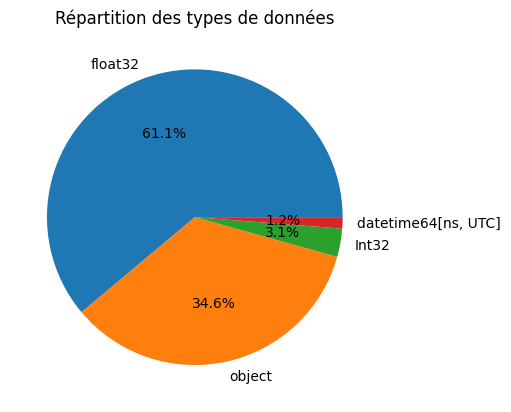

In [14]:
# Répartition du type de variable
compteur_type_variable(data_brut, False, False, True)

## <span style='background:green'>Résumé des données</span>

Quantitatives

In [15]:
# Résumé des variables quantitatives
data_brut.describe(exclude=[np.object_])

,created_t,created_datetime,last_modified_t,last_modified_datetime,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,butyric-acid_100g,caproic-acid_100g,caprylic-acid_100g,capric-acid_100g,lauric-acid_100g,myristic-acid_100g,palmitic-acid_100g,stearic-acid_100g,arachidic-acid_100g,behenic-acid_100g,lignoceric-acid_100g,cerotic-acid_100g,montanic-acid_100g,melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,alpha-linolenic-acid_100g,eicosapentaenoic-acid_100g,docosahexaenoic-acid_100g,omega-6-fat_100g,linoleic-acid_100g,arachidonic-acid_100g,gamma-linolenic-acid_100g,dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,oleic-acid_100g,elaidic-acid_100g,gondoic-acid_100g,mead-acid_100g,erucic-acid_100g,nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,sucrose_100g,glucose_100g,fructose_100g,...,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
count,320749.0,320748,320749.0,320749,248961.0,248961.0,248961.0,2.61136e+05,857.00000,243914.00000,229577.00000,0.0,0.0,1.0,2.00000,4.00000,1.0,1.0,1.0,1.000,0.0,0.0,0.0,1.0,0.0,22823.00000,22859.00000,841.00000,186.00000,33.00000,55.00000,188.00000,149.00000,8.00000,1.000,0.0,21.00000,13.00000,0.0,0.0,0.0,0.0,0.0,143298.00000,144090.00000,243611.00000,244994.00000,72.00000,26.00000,38.00000,...,259929.00000,27.00000,16.00000,9.00000,255533.00000,255486.00000,4133.00000,137554.00000,34.00000,7.07100e+03,1340.00000,9.18000e+02,140867.00000,11154.00000,10815.00000,11719.00000,6784.00000,5240.00000,3042.00000,5.30000e+03,3.07000e+02,2460.00000,3.80000e+01,8.10000e+01,24748.00000,1.58000e+02,141066.00000,5845.00000,140462.00000,6253.00000,3929.00000,2106.00000,1620.00000,79.00000,1.16800e+03,2.00000e+01,1.10000e+01,259.00000,78.00000,29.00000,49.00000,3046.00000,165.00000,948.00000,0.0,268.00000,221233.00000,221233.00000,0.0,0.0
mean,1470622403.13755,2016-08-08 03:29:48.115171584+00:00,1478938315.56608,2016-11-12 08:11:55.566074880+00:00,1.93638,0.01966,0.05525,1.14184e+03,585.50116,12.72937,5.12956,NaN,NaN,7.4,6.04000,36.13618,18.9,8.1,3.0,0.064,NaN,NaN,NaN,61.0,NaN,10.42506,6.31249,3.18210,2.25029,3.61755,0.74229,16.22914,3.82382,0.05700,0.095,NaN,40.19286,25.12308,NaN,NaN,NaN,NaN,NaN,0.07348,0.02007,32.07201,16.00298,11.84167,2.87885,25.89737,...,7.07607,4.65815,2.50625,0.02168,2.02846,0.79875,7.83811,0.00040,0.51872,7.95609e-06,0.05670,3.42193e-02,0.02337,0.32557,0.25901,0.01478,0.02338,0.00690,0.20586,8.93870e-05,1.96282e-02,0.05899,1.31227e-02,1.19052e-01,0.42464,9.26382e-02,0.12517,0.61728,0.00365,0.53414,0.00795,0.02579,0.00301,0.01216,3.12595e-03,1.69017e-03,4.00691e-04,0.00043,1.59456,0.14576,6.42570,31.37662,15.41212,49.54778,NaN,341.70078,9.16474,9.05726,NaN,NaN
min,0.0,2012-01-31 14:43:58+00:00,1332368132.0,2012-03-21 22:15:32+00:00,0.0,0.0,0.0,0.00000e+00,0.00000,0.00000,0.00000,NaN,NaN,7.4,5.88000,0.04473,18.9,8.1,3.0,0.064,NaN,NaN,NaN,61.0,NaN,0.00000,0.00000,0.00000,0.00000,0.05000,0.04100,0.05000,0.09000,0.00700,0.095,NaN,1.00000,1.08000,NaN,NaN,NaN,NaN,NaN,-3.57000,0.00000,0.00000,-17.86000,0.00000,0.00000,0.00000,...,-800.00000,0.92000,0.30000,0.01550,0.00000,0.00000,0.00000,-0.00034,0.00000,0.0000

Qualitatives

_Pas exécuté car la cellule dure > 10 minutes._

In [16]:
# Résumé des variables qualitatives
# data_brut.describe(exclude=[np.number])

## <span style='background:green'>Valeurs manquantes</span>

Valeurs manquantes (Nan) : 39604863 / 51961338 données (76.22 %)
154 / 162 colonne(s) sont concernés
----------------------------------------------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


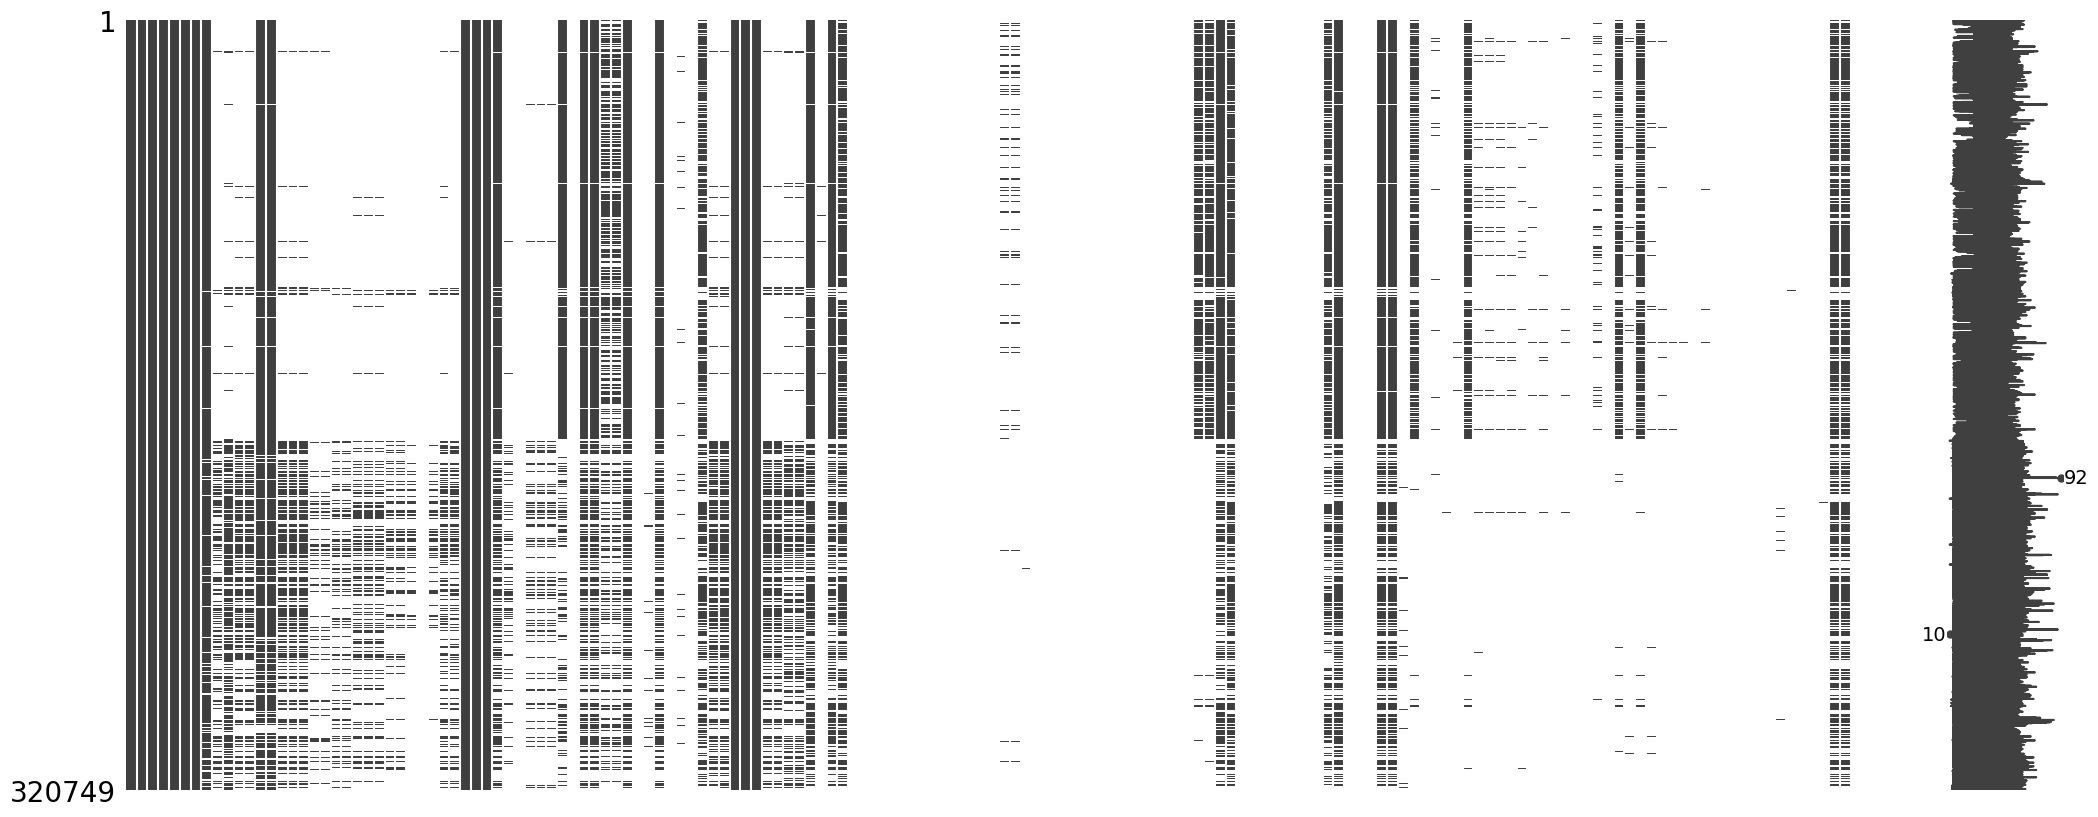

In [17]:
# Tableau et matrice des valeurs manquantes
valeur_manquante_text_graph(data_brut, False, True)

## <span style='background:green'>Doublons</span>

In [134]:
# Detection des doublons sur la variable du code
first = detect_doublon(data_brut, 'code', 'first')
first = detect_doublon(data_brut, 'code', 'last')
false = detect_doublon(data_brut, 'code', False)

Doublons détecté(s) avec "first" sur "code" : 0
Doublons détecté(s) avec "last" sur "code" : 0
Doublons détecté(s) avec False sur "code" : 0



___
**Bilan sur le jeu de données 'fr.openfoodfacts.org.products.csv'**: 
___
-   Le jeu de données contient **320_749 lignes et 162 colonnes**.
<br><br>
- Le dataset contient des informations sur les aliments : 
  - **temporelle** (*_t) : UNIX timestamp
  - **temporelle** (*_datetime) : date dans le fomat iso8601 (yyyy-mm-ddThh:mn:ssZ)
  - **étiquetage** (*_tags) : étiquette séparée par des virgules
  - **language** (*_fr) : tags en langue française
  - **nutritif** (*_100g) : quantité de nutriment (en g ou en kJ d'énergie) pour 100g ou 100 mL de produit
  - **nutritif** (*_serving) : quantité de nutriment (en g ou en kJ d'énergie) pour l'ingestion d'1 produit
<br><br>
- type de données :
  - **61,1% de nombre décimaux numérique** : 
  - **34,6% de texte**
  - 3,1% d'entier numériques
  - 1,2% de datetime
<br><br>
-   valeurs manquantes : 
    -   39_604_863  de NaN pour 51_961_338  observations (**76.22 %**).
    -   154 / 162 colonnes concernées
<br><br>
-   **Pas de doublons** sur la col 'code'.
<br><br><br>

# <span style='background:blue'>Etape 2 : Nettoyage des données</span>
___

## <span style='background:green'>1/ Filtrage par taux de remplissage</span>

In [100]:
# Seuil_NaN
seuil_nan = 50

# Affichage graphique des NaN
df_Nan_par_ligne, df_to_supp = filtre_nan_par_seuil(data_brut, seuil_nan, False)

# Suppression col > 50% de NaN
df_data_clean_nan = data_brut.drop(columns=df_to_supp.index)

# Affichage
print("Voici les colonnes : ")
display(df_to_supp)

affiche_aperçu_df(df_data_clean_nan, "df_data_clean_nan", "des NaN", 2)

Il y a 128 colonnes > 50 % de NaN
Voici les colonnes : 


,nombre,pourcent
additives_fr,166047.0,51.8
additives_tags,166047.0,51.8
cholesterol_100g,176659.0,55.1
trans-fat_100g,177451.0,55.3
calcium_100g,179683.0,56.0
vitamin-c_100g,179882.0,56.1
iron_100g,180287.0,56.2
vitamin-a_100g,183195.0,57.1
quantity,215949.0,67.3
pnns_groups_2,226235.0,70.5



Voici l'aspect de 'df_data_clean_nan' après nettoyage des NaN


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,brands,brands_tags,countries,countries_tags,countries_fr,ingredients_text,serving_size,additives_n,additives,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,states,states_tags,states_fr,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17 09:17:46+00:00,1474103893,2016-09-17 09:18:13+00:00,Farine de blé noir,Ferme t'y R'nao,[ferme-t-y-r-nao],en:FR,[en:france],France,NaN,NaN,<NA>,NaN,<NA>,<NA>,NaN,"en:to-be-completed, en:nutrition-facts-to-be-c...","[en:to-be-completed, en:nutrition-facts-to-be-...","A compléter,Informations nutritionnelles à com...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09 14:32:37+00:00,1489069957,2017-03-09 14:32:37+00:00,Banana Chips Sweetened (Whole),NaN,<NA>,US,[en:united-states],États-Unis,"Bananas, vegetable oil (coconut oil, corn oil ...",28 g (1 ONZ),0,[ bananas -> en:bananas ] [ vegetable-oil -...,0,0,d,"en:to-be-completed, en:nutrition-facts-complet...","[en:to-be-completed, en:nutrition-facts-comple...","A compléter,Informations nutritionnelles compl...",2243.0,28.57,28.57,64.29,14.29,3.6,3.57,0.0,0.0,14.0,14.0


320749 ligne(s) x 34 colonne(s)



## <span style='background:green'>2/ Suppression colonnes redondantes</span>

Certaines col/variables dans le dataset sont des variables redondantes. C'est le cas par exemple des variables suffixées par '_tags' ou '_fr' qui ne font que reprendre d'autres variables traduites ou simplifiées.

C'est par exemple de cas des variables 'countries' :

In [20]:
category_columns = ['countries','countries_tags','countries_fr']

df_data_clean_nan[df_data_clean_nan[category_columns].notnull().any(axis=1)][['product_name'] + category_columns].sample(5)

,product_name,countries,countries_tags,countries_fr
232505,Brûle-Graisse,France,[en:france],France
131434,Classic Pizza,US,[en:united-states],États-Unis
236768,La Sélection des Médaillés,France,[en:france],France
165621,"Bacon, Uncured Bacon, Chipotle",US,[en:united-states],États-Unis
291780,NaN,Suisse,[en:switzerland],Suisse


On remarque dans ces quelques exemples que les variables sont bien redondantes. Nous souhaitons conserver les variables pour la France (suffixe '*_fr'). Nous allons donc agir de la façon suivante : 
- Suffixe '*_fr' détecté => supprimer la colonne sans le suffixe (si elle existe)
- Suffixe '\*_tags' détecté => supprimer la colonne avec le suffixe '\*_tags'

In [21]:
# Detection des col à supprimer
col_a_supp = filtre_fr_tags(df_data_clean_nan)

9 brands_tags          'Sans suffixe' -> True donc on supprime la variable tags : 'brands_tags'
11 countries_tags       'Sans suffixe' -> True donc on supprime la variable tags : 'countries_tags'
12 countries_fr         'Sans suffixe' -> True donc on supprime la variable pas française : 'countries'
19 nutrition_grade_fr   'Sans suffixe' -> False donc on supprime la variable pas française : 'nutrition_grade'
21 states_tags          'Sans suffixe' -> True donc on supprime la variable tags : 'states_tags'
22 states_fr            'Sans suffixe' -> True donc on supprime la variable pas française : 'states'


Les dates également comportent une certaine redondance. Entre les timestamp et les dates au format "yyyy-mm-dd", il est nécessaire d'en éliminer :

In [22]:
category_columns = ['created_t','created_datetime']

df_data_clean_nan[df_data_clean_nan[category_columns].notnull().any(axis=1)][['product_name'] + category_columns].sample(5)

,product_name,created_t,created_datetime
145475,"Nutwhats, Pretzel Scribble, Peanut",1489075531,2017-03-09 16:05:31+00:00
241712,Chiffonade de Jambon sec,1415288328,2014-11-06 15:38:48+00:00
161523,"Badger Max, Sports Drink, Grape",1489073957,2017-03-09 15:39:17+00:00
72851,Tortilla Chips,1489072463,2017-03-09 15:14:23+00:00
241582,Eau de source de montagne,1474975247,2016-09-27 11:20:47+00:00


Ca ne se voit pas à l'oeil nu mais la date au format UNIX ('created_t') correspond au à la date au format iso8601 ('created_datetime')
<br>Nous allons donc supprimer le format UNIX pour garder uniquement le format iso8601

In [23]:
for col in df_data_clean_nan.columns.values:
    if col.endswith('_t'):
        col_a_supp.append(col)

Nous réalisons la suppresion des cols redondantes (sans suffixe, tags et UNIX)

In [102]:
# Suppression col redondantes
df_data_clean_nan_redon = df_data_clean_nan.drop(columns=col_a_supp)

# Affichage
print("Voici les colonnes qui ont été supprimées: ")
display(pd.DataFrame(col_a_supp, columns=["nom_col"]))

affiche_aperçu_df(df_data_clean_nan_redon, "df_data_clean_nan_redon", "des col redondantes", 3)

Voici les colonnes qui ont été supprimées: 


,nom_col
0,brands_tags
1,countries_tags
2,countries
3,states_tags
4,states
5,created_t
6,last_modified_t



Voici l'aspect de 'df_data_clean_nan_redon' après nettoyage des col redondantes


,code,url,creator,created_datetime,last_modified_datetime,product_name,brands,countries_fr,ingredients_text,serving_size,additives_n,additives,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,states_fr,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,2016-09-17 09:17:46+00:00,2016-09-17 09:18:13+00:00,Farine de blé noir,Ferme t'y R'nao,France,NaN,NaN,<NA>,NaN,<NA>,<NA>,NaN,"A compléter,Informations nutritionnelles à com...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,2017-03-09 14:32:37+00:00,2017-03-09 14:32:37+00:00,Banana Chips Sweetened (Whole),NaN,États-Unis,"Bananas, vegetable oil (coconut oil, corn oil ...",28 g (1 ONZ),0,[ bananas -> en:bananas ] [ vegetable-oil -...,0,0,d,"A compléter,Informations nutritionnelles compl...",2243.0,28.57,28.57,64.29,14.29,3.6,3.57,0.000,0.00,14.0,14.0
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,2017-03-09 14:32:37+00:00,2017-03-09 14:32:37+00:00,Peanuts,Torn & Glasser,États-Unis,"Peanuts, wheat flour, sugar, rice flour, tapio...",28 g (0.25 cup),0,[ peanuts -> en:peanuts ] [ wheat-flour -> ...,0,0,b,"A compléter,Informations nutritionnelles compl...",1941.0,17.86,0.00,60.71,17.86,7.1,17.86,0.635,0.25,0.0,0.0


320749 ligne(s) x 27 colonne(s)



## <span style='background:green'>3/ Suppression colonnes inutiles</span>

Voici la liste des colonnes restantes dans 'df_data_clean_nan_redon'

In [25]:
for i, col in enumerate(df_data_clean_nan_redon.columns):
    print(i, col)

0 code
1 url
2 creator
3 created_datetime
4 last_modified_datetime
5 product_name
6 brands
7 countries_fr
8 ingredients_text
9 serving_size
10 additives_n
11 additives
12 ingredients_from_palm_oil_n
13 ingredients_that_may_be_from_palm_oil_n
14 nutrition_grade_fr
15 states_fr
16 energy_100g
17 fat_100g
18 saturated-fat_100g
19 carbohydrates_100g
20 sugars_100g
21 fiber_100g
22 proteins_100g
23 salt_100g
24 sodium_100g
25 nutrition-score-fr_100g
26 nutrition-score-uk_100g


Nous allons enlever les col inutiles : url, créateur et cacul du nutriscore pour le Royaume Uni

In [101]:
# Liste des col inutiles
col_inutiles = ["url", "creator", "nutrition-score-uk_100g"]

# Suppression des col inutiles
df_data_clean_nan_redon_utile = df_data_clean_nan_redon.drop(columns=col_inutiles)

# Affichage
print("Voici les colonnes qui ont été supprimées: ")
display(pd.DataFrame(col_inutiles))

affiche_aperçu_df(df_data_clean_nan_redon_utile, "df_data_clean_nan_redon_utile", "des col inutiles", 3)

Voici les colonnes qui ont été supprimées: 


,0
0,url
1,creator
2,nutrition-score-uk_100g



Voici l'aspect de 'df_data_clean_nan_redon_utile' après nettoyage des col inutiles


,code,created_datetime,last_modified_datetime,product_name,brands,countries_fr,ingredients_text,serving_size,additives_n,additives,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,states_fr,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g
0,0000000003087,2016-09-17 09:17:46+00:00,2016-09-17 09:18:13+00:00,Farine de blé noir,Ferme t'y R'nao,France,NaN,NaN,<NA>,NaN,<NA>,<NA>,NaN,"A compléter,Informations nutritionnelles à com...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,2017-03-09 14:32:37+00:00,2017-03-09 14:32:37+00:00,Banana Chips Sweetened (Whole),NaN,États-Unis,"Bananas, vegetable oil (coconut oil, corn oil ...",28 g (1 ONZ),0,[ bananas -> en:bananas ] [ vegetable-oil -...,0,0,d,"A compléter,Informations nutritionnelles compl...",2243.0,28.57,28.57,64.29,14.29,3.6,3.57,0.000,0.00,14.0
2,0000000004559,2017-03-09 14:32:37+00:00,2017-03-09 14:32:37+00:00,Peanuts,Torn & Glasser,États-Unis,"Peanuts, wheat flour, sugar, rice flour, tapio...",28 g (0.25 cup),0,[ peanuts -> en:peanuts ] [ wheat-flour -> ...,0,0,b,"A compléter,Informations nutritionnelles compl...",1941.0,17.86,0.00,60.71,17.86,7.1,17.86,0.635,0.25,0.0


320749 ligne(s) x 24 colonne(s)



## <span style='background:green'>3/ Conservation des produis disponibles en France</span>

Tout d'abord, nous allons regarder le nombre de valeur manquante dans la colonne des pays

In [27]:
nan_pays_pourcent = df_Nan_par_ligne.loc["countries_fr"]["pourcent"]
print("{0} % de valeurs manquantes dans la col des pays".format(nan_pays_pourcent))

0.1 % de valeurs manquantes dans la col des pays


Nous allons regarder les pays présent dans le dataset

In [28]:
pays_unique = df_data_clean_nan_redon_utile["countries_fr"].unique()
df_pays_unique = pd.DataFrame(pays_unique, columns=["pays"])

print("Il y a", df_pays_unique.shape[0], "pays différents dans le dataset 'df_data_clean_nan_redon_utile'")
display(pd.DataFrame(df_pays_unique).head(15))

Il y a 718 pays différents dans le dataset 'df_data_clean_nan_redon_utile'


,pays
0,France
1,États-Unis
2,Royaume-Uni
3,"France,États-Unis"
4,Canada
5,Suisse
6,Espagne
7,Allemagne
8,Slovénie
9,Italie


Or nous remarquons que plusieurs pays sont regroupés dans la même variable, nous allons devoir effectuer un split du texte avec une virgule pour visualiser tous nos pays :

In [60]:
pays_virgule = split_nom_pays(df_data_clean_nan_redon_utile, col='countries_fr', sep=",")

df_pays_virgule = pd.DataFrame(pays_virgule, columns=["pays"])

display(df_pays_virgule.head(5))

,pays
0,France
1,États-Unis
2,États-Unis
3,États-Unis
4,États-Unis


Mais si on affiche toutes les noms de pays ainsi trouvé, on peut voir qu'il y a encore des noms pays non conventionnels 

In [47]:
pays_virgule_unique = df_pays_virgule["pays"].unique()
df_pays_virgule_unique = pd.DataFrame(pays_virgule_unique, columns=['pays']).sort_values(by="pays").reset_index(drop=True)

print("Il y a", df_pays_virgule_unique.shape[0], "pays différents après le split par la virgule")
display(df_pays_virgule_unique)

Il y a 266 pays différents après le split par la virgule


,pays
0,77-provins
1,Afrique du Sud
2,Aix-en-provence
3,Albanie
4,Algérie
5,Allemagne
6,Andorre
7,Angola
8,Arabie saoudite
9,Argentine


On remarque qu'il y a plusieurs problèmes d'écriture des pays sur certaines lignes :
- Des villes, des régions et des départements français (parfois avec le numéro de département)
- Le pays est écrit en anglais, allemand, néerlandais, chinois, arabe, hongrois, portugais, japonais, russe, thaï, indi
- Le monde entier est nommé dans différentes langues (Worldwide, Weltweit, Global-market)
- Il y a écrit des préfixes avec ':' devant le pays relatif à des pays (de:, en:, es:, nl:, xx:)
- Il y a des pays avec des accents sur la première lettre du pays (qui est une voyelle)

Nous effectuons un split du texte avec ':' pour récupérer les pays qui ont ce problème :

In [67]:
pays_2p = split_nom_pays(df_pays_virgule_unique, col='pays', sep=":")

df_pays_2p = pd.DataFrame(pays_2p, columns=["pays"])

print("Il y a", df_pays_2p.shape[0], "pays après le split par ':'")

Il y a 266 pays après le split par ':'


Nous ne garderons pas les pays qui sont des villes ou région française car elles ne représente pas l'intégralité de la France.


Nous allons conserver tous les noms de pays qui concernent : 
- La France
- Le monde entier

Nous ferons cela dans toutes les langues trouvées

In [94]:
# FRANCE 
# en anglais, allemand, néerlandais, chinois, arabe, hongrois, portugais, japonais, russe, thaï, indi
noms_france = ["France", "Frankreich", "Frankrijk", "法国", "فرنس", "Franciaország", "França", "フランス", "Франция", "ฝรั่งเศส", "फ़्रांस"]

# MONDE ENTIER
monde_list = ["Union européenne", "Weltweit", "Worldwide", "Global-market", "All-over-the-world", "World"]

# Conservation des mots des 2 listes trouvées dans le df (trié)
df_france_et_monde = df_pays_2p[df_pays_2p["pays"].isin(noms_france + monde_list)].sort_values(by="pays")

# Affichage des valeurs différentes pour la France
france_unique = df_france_et_monde["pays"].unique()
df_france = pd.DataFrame(france_unique, columns=["pays"])

print("Voici les noms relatifs à la France trouvés dans 'df_pays_2p' : ")
display(df_france)

Voici les noms relatifs à la France trouvés dans 'df_pays_2p' : 


,pays
0,All-over-the-world
1,France
2,Frankreich
3,Frankrijk
4,Global-market
5,Union européenne
6,Weltweit
7,World
8,Worldwide


Nous allons filtrer le df des données en extrayant uniquement les lignes où le pays est un de ces termes en lien avec la France ou le monde

In [106]:
# Filtrer les lignes en lien avec la France
df_data_clean_france = df_data_clean_nan_redon_utile[df_data_clean_nan_redon_utile['countries_fr'].isin(df_france["pays"])]

# Affichage
affiche_aperçu_df(df_data_clean_france, "df_data_clean_france", "des pays monde et France", 3)

Voici l'aspect de 'df_data_clean_france' après nettoyage des pays monde et France


,code,created_datetime,last_modified_datetime,product_name,brands,countries_fr,ingredients_text,serving_size,additives_n,additives,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,states_fr,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g
0,0000000003087,2016-09-17 09:17:46+00:00,2016-09-17 09:18:13+00:00,Farine de blé noir,Ferme t'y R'nao,France,NaN,NaN,<NA>,NaN,<NA>,<NA>,NaN,"A compléter,Informations nutritionnelles à com...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,0000000024600,2015-06-17 08:45:04+00:00,2015-06-17 10:11:54+00:00,Filet de bœuf,NaN,France,NaN,NaN,<NA>,NaN,<NA>,<NA>,NaN,"A compléter,Informations nutritionnelles à com...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,0000000027205,2016-03-17 18:17:10+00:00,2016-03-17 18:17:18+00:00,NaN,NaN,France,NaN,NaN,<NA>,NaN,<NA>,<NA>,NaN,"A compléter,Informations nutritionnelles à com...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


94461 ligne(s) x 24 colonne(s)



## <span style='background:green'>4/ Suppression des doublons</span>

Comme nous l'avons vu dans la description du dataset, il n'y a aucun doublon dans la col 'code' des codes barres. 

En revanche, nous allons chercher les combinaisons de 'produit-marque' qui sont redondantes

In [149]:
# Comptage du nombre de "code" pour chaque combinaison 'produit-marque' non-nulles (ordre décroissant)
product_brand = df_data_clean_france[(df_data_clean_france["product_name"].isnull() == False) & (df_data_clean_france["brands"].isnull() == False)].groupby(by=["product_name","brands"])["code"].nunique().sort_values(ascending=False)

# Transformation df et affichage
df_product_brand = pd.DataFrame(product_brand)
display(df_product_brand)

code
product_name                            brands                   
Coca-Cola                               Coca-Cola              15
Pom'potes                               Materne                15
Orangina                                Orangina               13
Perrier                                 Perrier                10
Nutella                                 Ferrero                10
...                                                           ...
Flan pâtissier                          Leader Price            1
                                        LIDL                    1
                                        Casino                  1
Flan préparation pour entremets au café Abbaye de la Coudre     1
자연은 튼튼 (Jayeon-eun Teunteun)            자연은,Jayeon-eun          1

[78949 rows x 1 columns]

Il y 78_949 combinaisons 'produit-marque' différentes.

Voyons celles qui sont présentes plus d'une fois (donc des doublons)

In [150]:
# Filtre comptage du nombre de "code" > 1
df_product_brand_doublon = df_product_brand[df_product_brand["code"] > 1]

# Affichage
display(df_product_brand_doublon)

,,code
product_name,brands,
Coca-Cola,Coca-Cola,15
Pom'potes,Materne,15
Orangina,Orangina,13
Perrier,Perrier,10
Nutella,Ferrero,10
...,...,...
Crème Fraîche Épaisse Entière (30 % MG),Casino,2
Juicy Citron,Volvic,2
Le Torchon,Madrange,2


Il y a 2_140 combinaisons 'produits-marque' qui sont en doublon (2 fois ou plus)

In [173]:
# Suppression des doublons sur marque et produit en conservant les valeurs nulles
df_data_clean_doublon = df_data_clean_france[(~df_data_clean_france.duplicated(["product_name","brands"], keep="last")) | ((df_data_clean_france['product_name'].isnull()) & (df_data_clean_france['brands'].isnull()))]

# Affichage
affiche_aperçu_df(df_data_clean_doublon, "df_data_clean_doublon", "des doublons 'produit-marque'", 15)

Voici l'aspect de 'df_data_clean_doublon' après nettoyage des doublons 'produit-marque'


,code,created_datetime,last_modified_datetime,product_name,brands,countries_fr,ingredients_text,serving_size,additives_n,additives,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,states_fr,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g
0,0000000003087,2016-09-17 09:17:46+00:00,2016-09-17 09:18:13+00:00,Farine de blé noir,Ferme t'y R'nao,France,NaN,NaN,<NA>,NaN,<NA>,<NA>,NaN,"A compléter,Informations nutritionnelles à com...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,0000000024600,2015-06-17 08:45:04+00:00,2015-06-17 10:11:54+00:00,Filet de bœuf,NaN,France,NaN,NaN,<NA>,NaN,<NA>,<NA>,NaN,"A compléter,Informations nutritionnelles à com...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,0000000027205,2016-03-17 18:17:10+00:00,2016-03-17 18:17:18+00:00,NaN,NaN,France,NaN,NaN,<NA>,NaN,<NA>,<NA>,NaN,"A compléter,Informations nutritionnelles à com...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
136,0000000039259,2015-01-25 21:36:13+00:00,2016-09-10 20:08:02+00:00,Twix x2,NaN,France,NaN,NaN,<NA>,NaN,<NA>,<NA>,NaN,"A compléter,Informations nutritionnelles à com...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
182,0000005200016,2015-09-02 09:37:37+00:00,2015-09-18 10:05:52+00:00,lentilles vertes,Bertrand Lejeune,France,lentilles vertes,NaN,0,[ lentilles-vertes -> fr:lentilles-vertes ] ...,0,0,NaN,"A compléter,Informations nutritionnelles à com...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
183,0000007020254,2015-01-01 22:09:53+00:00,2015-01-02 14:52:53+00:00,NaN,A&W,France,NaN,NaN,<NA>,NaN,<NA>,<NA>,NaN,"A compléter,Informations nutritionnelles à com...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
184,0000007730009,2016-05-09 15:07:12+00:00,2016-12-21 22:25:50+00:00,Biscuits sablés fourrage au cacao,St Michel,France,"Sucre, farine de _Blé_, graisse et huiles végé...",NaN,3,[ sucre -> fr:sucre ] [ farine-de-ble -> fr...,0,1,NaN,"A vérifier,Complet,Informations nutritionnelle...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187,0000009336247,2016-11-13 09:37:57+00:00,2016-11-13 09:40:10+00:00,NaN,NaN,France,NaN,NaN,<NA>,NaN,<NA>,<NA>,NaN,"A compléter,Informations nutritionnelles à com...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
188,0000010090206,2013-06-11 19:03:51+00:00,2015-10-17 12:03:51+00:00,Thé de Noël aromatisé orange-cannelle,Alice Délice,France,"Thé noir de Chine, zestes d'oranges 7,5 %, arô...",NaN,0,[ the-noir-de-chine -> fr:the-noir-de-chine ...,0,0,NaN,"A vérifier,Complet,Informations nutritionnelle...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
189,0000010127735,2016-05-07 10:25:04+00:00,2016-05-09 15:01:36+00:00,Sirops pour ganache macarons,Alice Délice,France,"Sirop saveur pistache 5 cl : sirop 99,16 % (su...",NaN,4,[ sirop-saveur-pistache-5-cl -> fr:sirop-save...,0,0,NaN,"A vérifier,Complet,Informations nutritionnelle...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


90722 ligne(s) x 24 colonne(s)



Nous pouvons vérifier qu'il n'y a plus de doublon de combinaison 'produit-marque' dans le dataset

In [155]:
# Comptage du nombre de "code" pour chaque combinaison 'produit-marque' non-nulles (ordre décroissant)
product_brand_verif = df_data_clean_doublon[(df_data_clean_doublon["product_name"].isnull() == False) & (df_data_clean_doublon["brands"].isnull() == False)].groupby(by=["product_name","brands"])["code"].nunique().sort_values(ascending=False)

# Transformation df et affichage
df_product_brand_verif = pd.DataFrame(product_brand_verif)
display(df_product_brand_verif.head(3))

,,code
product_name,brands,
Bridelight 3% Les carrés fondants goût Emmental,Bridelight,1
Perrier fine bulle,Perrier,1
Perrier saveur citron vert lime,Perrier,1


C'est bon. La valeur la plus haute combinaison 'produit-marque' dans le dataset est = 1

## <span style='background:green'>5/ Filtrage valeur abérrantes</span>

Toutes les colonnes qui ont un nom qui termine par '_100g' sont des float

In [172]:
# Trie des col qui se termine par '_100g'
colonnes_100g = df_data_clean_doublon[[col for col in df_data_clean_doublon.columns if col.endswith('_100g')]]

# Répartition du type de variable par col
compteur_type_variable(colonnes_100g, True, False, False)

----------------------------------------------------------------------------------------------------
Type de variable pour chacune des variables



energy_100g                float32
fat_100g                   float32
saturated-fat_100g         float32
carbohydrates_100g         float32
sugars_100g                float32
fiber_100g                 float32
proteins_100g              float32
salt_100g                  float32
sodium_100g                float32
nutrition-score-fr_100g    float32
dtype: object

# Règles métiers

## Energie

Il faut savoir que les lipides sont la plus grande source de kcal par gramme ingéré, à raison de 9 kcal/g. Or 1 kcal = 4,18 Joules

Donc l'ingestion de 100g de lipides = 900 kcal = 3_762 J.

=> **L'energie par 100g doit être compris entre 0 et 3_762 J** 

Source : [Valeur énergétique sur Wikipedia](https://fr.wikipedia.org/wiki/Valeur_%C3%A9nerg%C3%A9tique)

Source : [Information nutritionnelle sur Wikipedia](https://fr.wikipedia.org/wiki/Information_nutritionnelle)

## Nutriment

La quantité en gramme affichée de nutriment ne peut pas dépassé la quantité de produit total. 

=> **La quantité de nutriment par 100g doit être compris entre 0 et 100g** 

Voici la liste des nutriments : 

Egalement certains nutriments sont des 'sous-nutriments' inclus dans d'autres nutriment comme :
- 'graisses saturées' fait parti de 'graisse'
- 'sucre' fait parti de 'glucide'
  

=> **La quantité de 'sous-nutriment' par 100g doit être < à celle du nutriment auquel il appartient** 

Source : [Information nutritionnelle sur Wikipedia](https://fr.wikipedia.org/wiki/Information_nutritionnelle)


## Nutri-score

Le Nutri-Score est une échelle graphique qui scinde le **score nutritionnel** en 5 classes (exprimées
par une couleur associée à une lettre) et vise à faciliter la visibilité, la lisibilité, et la compréhension
de la valeur nutritionnelle par le consommateur.

Le **score nutritionnel** est calculé à l’aide de la déclaration nutritionnelle pour 100g ou 100 mL de produits tel
que vendu (sauf exceptions) et de la liste des ingrédients. Les points sont attribués en fonction de la teneur
des éléments suivants :

- Eléments « défavorables », dont l’excès est considéré comme délétère pour la santé : l’énergie en
kJ, les sucres, le sel et les acides gras saturés (et les édulcorants non-nutritifs pour l’algorithme
adapté aux boissons)<br><br>
- Eléments « favorables » : protéines, fibres, fruits, légumes et légumes secs (huiles de noix, colza et
d’olives pour la méthode de calcul datant de 2017).

=> **Le score nutritionnel en France doit être compris entre -15 et +40** 

Source : [NUTRI-SCORE Questions & Réponses de Santé publique France](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwjqxJ7p8KyBAxXDUqQEHRpiBeoQFnoECBUQAQ&url=https%3A%2F%2Fwww.santepubliquefrance.fr%2Fmedia%2Ffiles%2F02-determinants-de-sante%2Fnutrition-et-activite-physique%2Fnutri-score%2Ffaq_fr&usg=AOvVaw0WQv0l_eVKgvmWEjnUAVZC&opi=89978449)

## <span style='background:green'>6/ Imputation valeurs manquantes par produit</span>

## <span style='background:green'>7/ Traitement certaines variables catégorielles</span>